# CS413 Image and Video Analysis -- Lab 9

## Department of Computer Science, University of Warwick
## November, 2019


## Aims:

The aims of this lab are to 

+ Learn how to implement a CNN using Keras
+ Explore variations of the convolution/max-pooling/dropout layer sandwiches
+ Learn about under and overfitting
+ Investigate the effects of numbers of epochs, batch size, learning rate and drop-out layers
+ Learn how to plot learning histories 
+ Evaluate and predict using a trained model and measure classification accuracy

## Working on Google CoLabs -- Accessing data

You will probably want to run this lab on GoogleCoLabs, in which case, to simplest way to access data 
is to attach your Google Drive directory to the Google CoLabs session by using the following code:

Note for this Lab you only need to have the COIL-100 data which can be directly accessed from here

http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip


~~~
# mount your local drive
from google.colab import drive
drive.mount('/content/drive')

# list the contents of your drive and the lab data directory
!ls /content/drive/My\ Drive/data

# then to say read an image called 'some-image.png' you need to do something like this 
data_dir = 'drive/My Drive/data/'
im = cv2.read(data_dir + 'some-image.png')
~~~

In [1]:
import os
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2 # opencv


## COIL-100 data

Load up the COIL-100 data as we have done previously.

In [2]:
num_classes = 100

data_dir = '/modules/cs413/data/coil-100/' # or 'drive/My Drive/data/coil-100/' on Google Drive

images = []
classes = []
example_images = []
do_limit = False
max_per_class = 32
for i in range(num_classes):

    filenames = glob.glob(data_dir + 'obj' + str(i+1) + '_*.png')
    
    for j in range(len(filenames)):
        
        im_gbr = cv2.imread(filenames[j])
        im = cv2.cvtColor(im_gbr,cv2.COLOR_BGR2RGB) # convert from BGR ordering to RGB

        images.append(im)
        classes.append(i)

        if (j==0):
            example_images.append(im) # keep and example of each class
            
        # limit to 10 images per example
        if do_limit:
            if (j==9):
                break



## Keras imports

Import Keras model `Sequential` so we can `add` Keras layers. 

In this Lab we will just use the two layers:
~~~
    Conv2D  
    MaxPooling2D
    Dense
~~~

And the operations `Flatten` and `Dropout`.



In [3]:
import os

import keras
from keras.models import Sequential


from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

## Exercise -- Data Wrangling

Start by wrangling the data so that it in two arrays `x` and `y` which contain the image data and the classes.

Normalise the image data to have range [0,1] and use `sklearn.utils.shuffle` to randomize the locations of the 
x-y pairs. 

Then make a training-validation split (e.g. 70% training, 30% validation) and put the subsets into two pairs 
of variables: `x_train, y_train` and 'x_val, y_val'.
    
Print out the shapes of these variables.

In [108]:
# convert data to numpy arrays and normalize
# x = ...
# y = ...

x = np.array(images).astype('float')/255.0
y = np.array(classes)

# shuffle the data
from sklearn.utils import shuffle
x, y = shuffle(x, y, random_state=0)
#x, y = shuffle(...)


print('x shape is ', x.shape)
print('y shape is ', y.shape)

# partition data
n70 = int(0.7 * x.shape[0])
n30 = x.shape[0] - n70

# x_train, x_val = 
# y_train, y_val = 

x_train, x_val = x[:n70], x[n70:]
y_train, y_val = y[:n70], y[n70:]


print('x_train shape is ', x_train.shape)
print('x_val shape is ', x_val.shape)

x shape is  (7200, 128, 128, 3)
y shape is  (7200,)
x_train shape is  (5040, 128, 128, 3)
x_val shape is  (2160, 128, 128, 3)


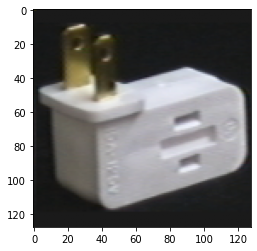

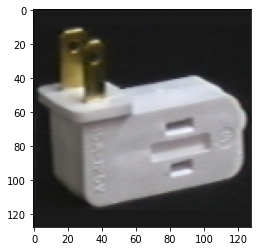

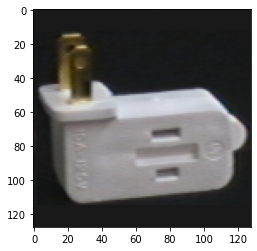

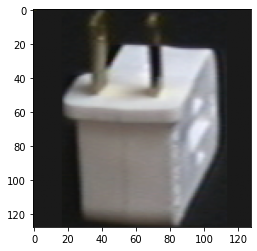

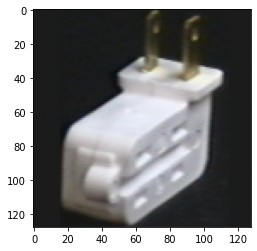

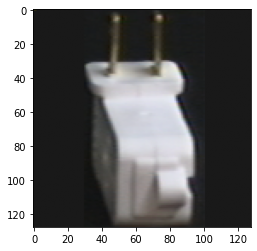

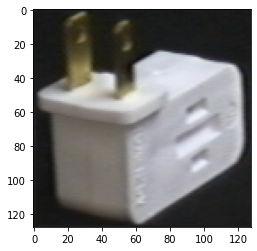

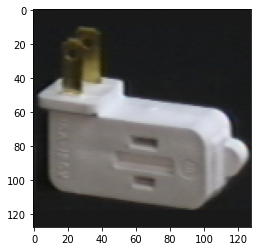

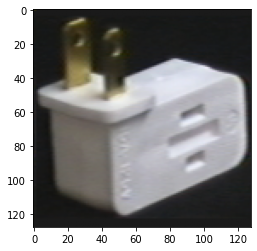

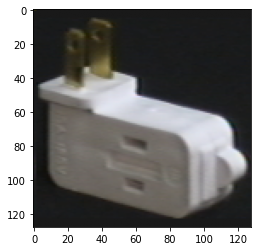

In [114]:
zeros = np.argwhere(y_val==56)


for i in range(10):
    plt.imshow(x_val[zeros[i][0]])
    plt.show()

## Which backend have you got?

This isn't a personal question!

Depending on the *backend* kernel you have on your Keras installation, the order of the axes in the 
network input will need to be either channel-first or channel-last.

We will need to confirm whether the kernel needs channel-first or channel-last and re-order the
data variables by using `np.reshape` as appropriate.

Use this incantantion which will set up the shape (`input_shape`) of the input-layer.


In [5]:
from keras import backend as K

# input image dimensions
img_rows, img_cols, num_channels = images[0].shape

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], num_channels, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], num_channels, img_rows, img_cols)
    input_shape = (num_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, num_channels)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, num_channels)
    input_shape = (img_rows, img_cols, num_channels)
    
print('input_shape is ', input_shape)

input_shape is  (128, 128, 3)


## Exercise -- One-hot-coding

Convert your training and validation output vectors, i.e. `y_train` and `y_val` to one-hot-coded vectors
using `keras.utils.to_categorical()`.



In [7]:

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

print('one hot coded', y_train[0], ', class is ', np.argmax(y_train[0]))

one hot coded [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] , class is  40


## Exercise -- Design Network

You are now ready to build your CNN.

Hint: Make a network with at least one convolution and one max-pooling and complete the network with
a dense layer with `num_classes` output neurons and a `softmax` activation. 

Start simple!

In [8]:
print('Input shape is ', input_shape)

model = Sequential()
#FEATURE DETECTOR
model.add(Conv2D(8, kernel_size=(8,8), 
                activation='relu',
                input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CLASSIFIER
model.add(Flatten())
# output layer with suitable activation
model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Input shape is  (128, 128, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 121, 121, 8)       1544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1843264   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)           

## Exercise -- Training/Fitting

Compile your network using an appropriate optimizer (e.g. `keras.optimizers.Adam()`)
and use an appropriate `batch_size` and number of `epochs` to fit your
training data. 


In [9]:
batch_size = 64 # you decide
epochs = 15 # you decide


model.compile(loss=keras.losses.CategoricalCrossentropy(), # choose a loss function
              optimizer=keras.optimizers.Adam(), # choose an optimizer 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))



Epoch 1/15
79/79 [==============================] - 28s 350ms/step - loss: 4.0175 - accuracy: 0.1293 - val_loss: 1.5968 - val_accuracy: 0.7042
Epoch 2/15
79/79 [==============================] - 26s 333ms/step - loss: 1.3720 - accuracy: 0.6854 - val_loss: 0.4295 - val_accuracy: 0.9083
Epoch 3/15
79/79 [==============================] - 27s 337ms/step - loss: 0.6246 - accuracy: 0.8332 - val_loss: 0.2323 - val_accuracy: 0.9551
Epoch 4/15
79/79 [==============================] - 26s 334ms/step - loss: 0.3670 - accuracy: 0.8955 - val_loss: 0.1769 - val_accuracy: 0.9648
Epoch 5/15
79/79 [==============================] - 26s 334ms/step - loss: 0.2949 - accuracy: 0.9202 - val_loss: 0.1246 - val_accuracy: 0.9708
Epoch 6/15
79/79 [==============================] - 26s 328ms/step - loss: 0.2062 - accuracy: 0.9437 - val_loss: 0.0803 - val_accuracy: 0.9838
Epoch 7/15
79/79 [==============================] - 26s 330ms/step - loss: 0.1576 - accuracy: 0.9494 - val_loss: 0.0648 - val_accuracy: 0.9829

## Exercise -- Training and validation / Optimizing the design

Use the `history` returned from the `fit()` function above, 
plot loss/accurcay curves during training and validation.

1. Are you satisfied the network is training without overfitting?
2. Is the final accuracy good enough? 
3. Do you need to change the batch size or the number of epochs?
4. Try adding `Dropout` after each max-pooling layer, e.g. 
~~~~
    model.add(Dropout(0.25)) # you can vary the the rate of dropout, e.g. 25%
~~~~
5. Do you need to change the learning rate of the optimizer?
6. Do you need to modify the design of your network?



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


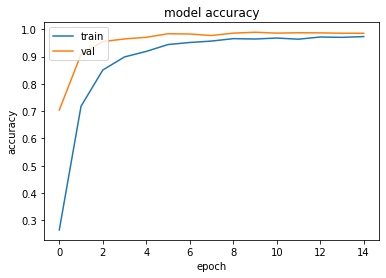

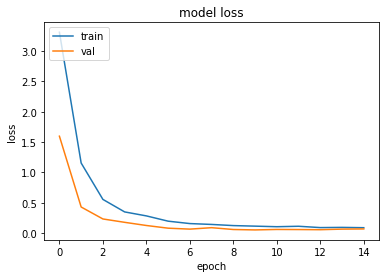

In [10]:
# this plots the change of accuracy and loss over time (stored in the 'history')

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Exercise -- Evaluate the accuracy of the model

Use the `model.evaluate()` function to find an accuracy score for the final model. 



In [11]:
score = model.evaluate(x_val, y_val, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0679469034075737
Test accuracy: 0.9856481552124023


## Exercise -- Confusion matrix

Use your model to predict the classes (`y_val_hat`) of the validation data (`x_val`) and 
calculate the entries of a confusion matrix over all the classes.

Print out the first 10 x 10 of this matrix.

Plot the matrix as an image.


In [13]:
def normalise_rows(confusion):
    row_sums = confusion.sum(axis=1)
    return confusion / row_sums

In [14]:
print('num classes is ', num_classes)

# predict classes from features and 
# compare with the true classes (which we know!) 
confusion = np.zeros((num_classes, num_classes))

for i in range(x_val.shape[0]):
    true_class = np.argmax(y_val[i])
    #pred_class = clf.predict(features[i]) # make prediction
    #pred_class = model.predict_classes(x_val[i])
    pred_class = np.argmax(model.predict(x_val[i].reshape(1,128,128,3)), axis=-1)
        
    #print('true/pred = ', true_class, '/', pred_class)
    confusion[true_class-1, pred_class-1] += 1
    
confusion = 100 * normalise_rows(confusion) # accuracy as a percentage

#confusion = confusion.transpose()
    
# just show the first 10 classes
print('confusion matrix is\n', np.round(confusion[:10,:10],1))

num classes is  100
confusion matrix is
 [[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]]


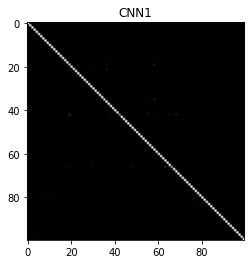

In [15]:
plt.imshow(confusion, 'gray')
plt.title("CNN1")
plt.show()

## Exercise -- Visualise K nearest-neighbour matches

Once you are satistfied with your classifier, use it visualise which are the nearest K images to a given query image.

Visualise also for any test image, which image not of that class, it matches with the highest accuracy (false-match).

Compare your results with the bag of visual words methods from Lab-8.


In [97]:
from keras import Model

In [98]:
def mse(x, y):
    return np.mean(np.square(x-y))

In [118]:
def k_nearest_neighbours(images, features, query_index, K=10):
    
    # calculate distance from image of class i to all others
    distances = []
    for i in range(0,len(features)):
        if (i!=query_index): # exclude itself
            distances.append(mse(features[query_index], features[i]))
            
    # sort by increasing distance and get the indices where these are
    indices = np.argsort(distances)

    closest_images = [images[k] for k in indices]
    closest_distances = [distances[k] for k in indices]

    # return K closest only
    return closest_images, closest_distances

In [119]:
layer_name = 'flatten'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
features = intermediate_layer_model.predict(x_val)

print(features.shape)
print(features)

(2160, 28800)
[[0.08860864 0.         0.07436191 ... 0.         0.05562242 0.06264165]
 [0.10250901 0.         0.08720246 ... 0.         0.05777663 0.07571705]
 [0.08860864 0.         0.07436191 ... 0.         0.05562242 0.06264165]
 ...
 [0.08860864 0.         0.07436191 ... 0.         0.05562242 0.06264165]
 [0.09426201 0.         0.07602075 ... 0.         0.05454922 0.06316075]
 [0.09426201 0.         0.07602075 ... 0.         0.05454922 0.06316075]]


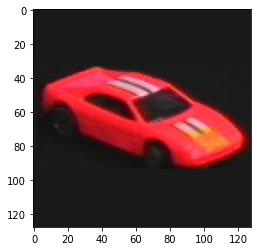

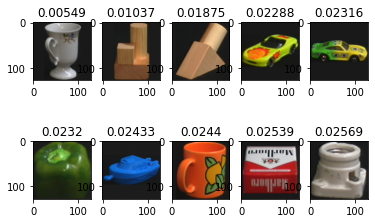

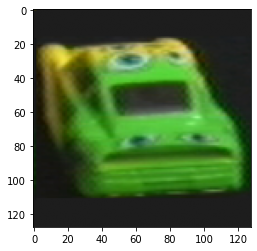

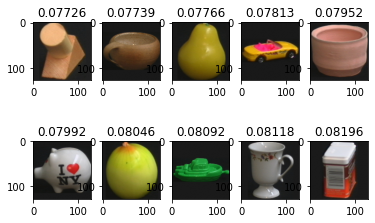

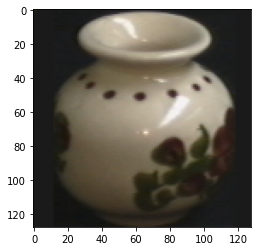

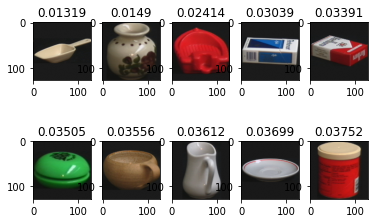

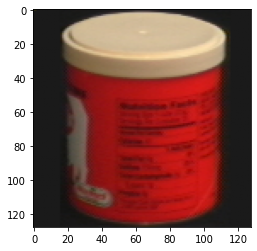

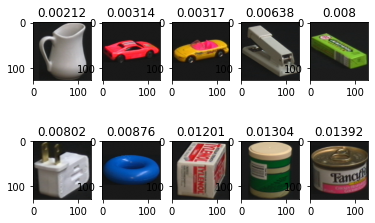

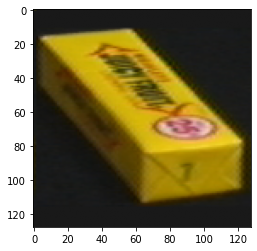

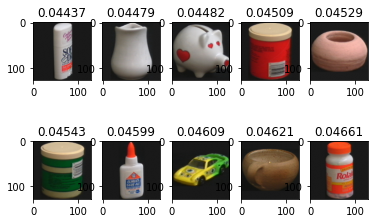

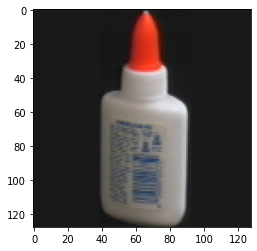

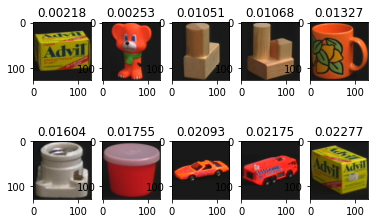

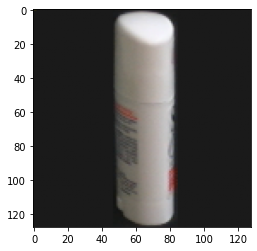

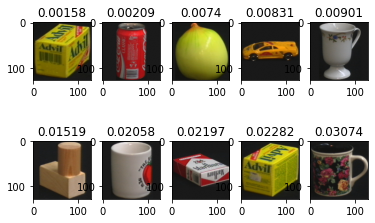

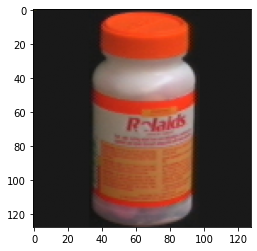

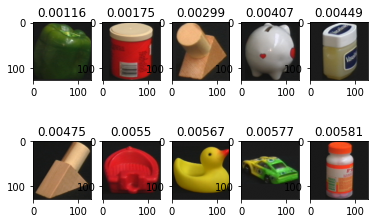

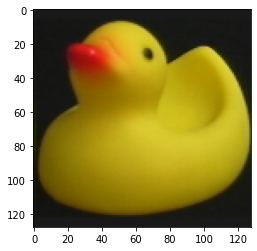

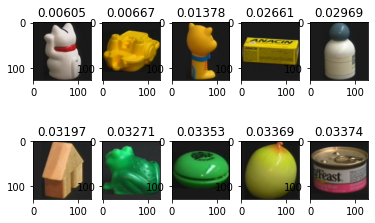

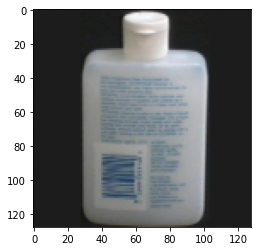

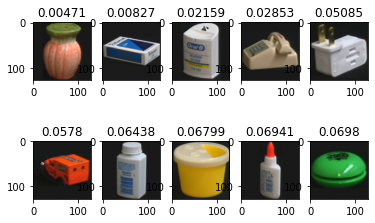

In [120]:
# try query image against 10 closest images from for first 10 classes
for i in range(0,100,10):
    
    # calculate distance from image of class i to all others
    closest_images, closest_distances = k_nearest_neighbours(x_val, features, i)
    
    # display closest images and their distances
    # ...fill in rest
    plt.imshow(x_val[i])
    plt.show()
    for j in range(10):
        plt.subplot(2, 5, j+1)
        plt.imshow(closest_images[j])
        plt.title(str(round(closest_distances[j], 5)))
    plt.show()

## Further Exercises


If you have got this far, then well done!

You should be now be in a good position to explore what you can do with CNNs using Keras.  

You might like to run your network on the CIFAR10 data set which is built-in 
(you will probably need to do this on Google CoLabs).

Look at a Keras example where they do transfer learning, perhaps using VGG16 as the pre-trained network.

Implement a VGG16 pretrained network for the COIL-100 data.
